In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Turn off the warnings
import warnings
warnings.filterwarnings('ignore')

## Prepare the Dataset for training

In [3]:
# Import the dataframe 
df: pd.DataFrame = pd.read_csv('Datasets/trainingdata.csv')

In [4]:
# Removing unnecessary columns
columns_to_remove = [
    'werknemer_id',
    'klant_id',
    'geboortedatum',
    'geslacht_id',
    'geslacht',
    'status',
    'geslacht_id_Man',
    'geslacht_id_Vrouw',
    'stad',
    'status_jaar',                         
    'status_actief',                       
    'status_beëindigd',                                             
    'uitdienst_reden_Niet van toepassing',  
    'uitdienst_reden_Ontslag',             
    'uitdienst_reden_Vertrek',
    'startdatum',
    'einddatum',
    'datum',
    'leeftijd'
]

df.drop(columns=columns_to_remove, inplace=True)

In [5]:
# Import the dataframe  and change the order of the columns
column_order =  ['leeftijd_begin_dienst', 'reisafstand', 'dienstperiode', 'aantal_geboortes_pf',
          'afdeling_Accountant', 'afdeling_Administratief medewerker', 'afdeling_BI',
          'afdeling_Boekhouder', 'afdeling_Business analist', 'afdeling_Business controller',
          'afdeling_Business development', 'afdeling_Credit controller', 'afdeling_Financial controller',
          'afdeling_HR', 'afdeling_IT', 'afdeling_Legal', 'afdeling_Marketing',
          'afdeling_Office manager', 'afdeling_Project controller', 'business_unit_Detachering',
          'business_unit_Intern']

df = df[column_order]

# Split the dataset into training and testing data

In [6]:
# Data preparation
columns_to_drop = ['dienstperiode'] 

X = df.drop(columns=columns_to_drop, axis=1) 
y = df['dienstperiode'] 

# Split the dataframe into Training (80%) and Testing (20%) in order to train the models.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN model

In [7]:
# Model building and training
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
knn_model = grid_search.best_estimator_

knn_model.fit(X_train_scaled, y_train)

Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


KNeighborsClassifier(metric='euclidean')

In [8]:
# Predicting
y_pred = knn_model.predict(X_test_scaled)

# Evaluatie
accuracy: float = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Gedetailleerd rapport
print(classification_report(y_test, y_pred))

Accuracy: 0.14
              precision    recall  f1-score   support

           0       0.15      0.33      0.21        61
           1       0.20      0.30      0.24        76
           2       0.06      0.04      0.04        54
           3       0.11      0.13      0.12        30
           4       0.03      0.02      0.03        42
           5       0.07      0.07      0.07        43
           6       0.07      0.08      0.07        48
           7       0.12      0.19      0.15        53
           8       0.11      0.06      0.08        63
           9       0.05      0.10      0.07        50
          10       0.07      0.05      0.06        65
          11       0.12      0.04      0.06        74
          12       0.27      0.25      0.26        81
          13       0.25      0.25      0.25        60
          14       0.59      0.34      0.43        47
          15       0.00      0.00      0.00        21
          16       0.07      0.21      0.11        39
          17

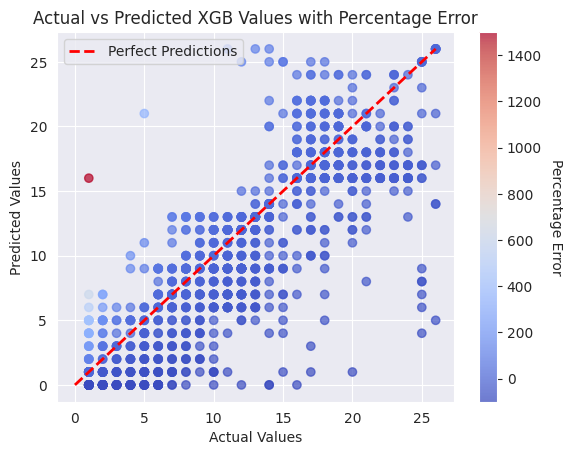

In [9]:
percentage_error: float = ((y_pred - y_test) / y_test) * 100 #Hoeveel percentage zit het model ernaast

plt.scatter(y_test, y_pred, c=percentage_error, cmap='coolwarm', alpha=0.7)

cbar: plt.colorbar = plt.colorbar()
cbar.set_label('Percentage Error', rotation=270, labelpad=15)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted XGB Values with Percentage Error')

plt.legend()
plt.show()

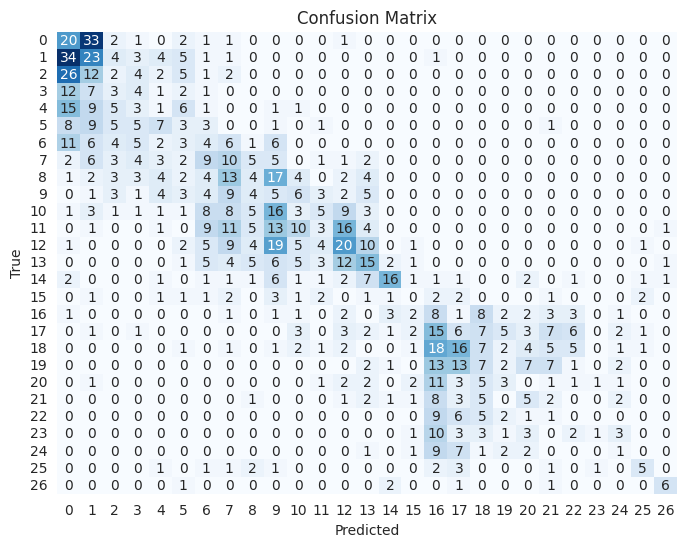

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Assume y_pred is your predicted values
y_pred_adjusted = np.maximum(y_pred, 2)

# Calculate the percentage of predictions within 30%
percentage_within_30_percent: float = np.sum(np.abs(y_test - y_pred_adjusted) <= 0.30 * y_test) / len(y_test) * 100

print(f"Adjusted percentage of predictions within 30% of actual dienstperiode (with minimum of 2 years): {percentage_within_30_percent:.2f}%")

Adjusted percentage of predictions within 30% of actual dienstperiode (with minimum of 2 years): 57.91%


In [12]:
pickle.dump(knn_model, open("saved_model.sav", "wb"))

# Train and XGBoost model 

In [13]:
max_depth_value = 5
xgb_model = XGBRegressor(max_depth=max_depth_value)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 7.829012395938365
R^2 Score: 0.8394018367213447


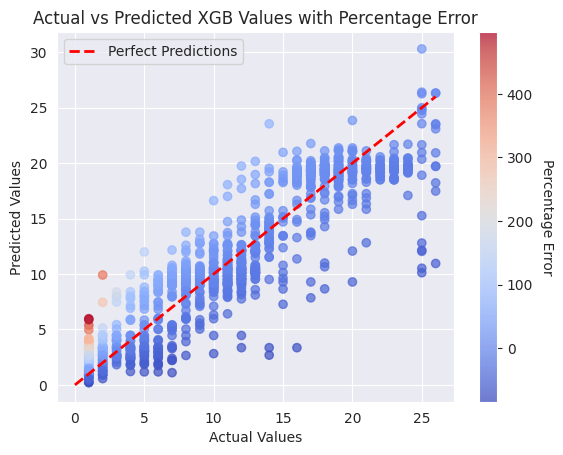

In [14]:
percentage_error = ((y_pred - y_test) / y_test) * 100 #Hoeveel percentage zit het model ernaast

plt.scatter(y_test, y_pred, c=percentage_error, cmap='coolwarm', alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Percentage Error', rotation=270, labelpad=15)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted XGB Values with Percentage Error')

plt.legend()
plt.show()


In [15]:
# Create a new temporary dataset to test the accuracy of the model
new_employee_data = pd.DataFrame({
    'leeftijd_begin_dienst' :[35],
    'reisafstand': [15],
    'aantal_geboortes_pf' : [5],
    'afdeling_Accountant': [0],
    'afdeling_Administratief medewerker': [0],
    'afdeling_BI': [0],
    'afdeling_Boekhouder': [0],
    'afdeling_Business analist': [0],
    'afdeling_Business controller': [0],
    'afdeling_Business development' :[0],
    'afdeling_Credit controller' :[0],
    'afdeling_Financial controller': [0],
    'afdeling_HR': [0],
    'afdeling_IT': [0],
    'afdeling_Legal': [0],
    'afdeling_Marketing': [1],
    'afdeling_Office manager': [0],
    'afdeling_Project controller': [0],
    'business_unit_Detachering': [1],
    'business_unit_Intern': [0],
})
              
predicted_dienstperiode = xgb_model.predict(new_employee_data)[0]
percentage_error_new_data = (abs((predicted_dienstperiode - y_test.mean())) / y_test.mean()) * 100

# Check if the prediction is within 20% off
if np.max(np.abs(percentage_error_new_data)) <= 20:
    print("Deze uitkomst is acceptabel.")
else:
    print("Deze uitkomst heeft een hogere kans op onnauwkeurigheid")

print(f"Verwachte dienstperiode: {predicted_dienstperiode:.2f} jaar")
print(f"Percentage afwijking van testset: {percentage_error_new_data:.2f}%") 

Deze uitkomst heeft een hogere kans op onnauwkeurigheid
Verwachte dienstperiode: 18.24 jaar
Percentage afwijking van testset: 61.84%


# Linear regression

In [16]:
lin_model = LinearRegression()

lin_model.fit(X_train_scaled, y_train)

y_pred = lin_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

print('Coefficients:', lin_model.coef_)
print('Intercept:', lin_model.intercept_)

Mean Squared Error: 28.856789839160857
Coefficients: [ 2.41085015e+00 -2.45513943e-01  2.60112378e-01  2.83523260e+12
  7.36480280e+11  2.96521875e+12  3.27137700e+12  2.40445871e+12
 -3.27744055e+10  5.09963430e+11  2.22348667e+12  3.24749499e+12
  6.57443660e+11  4.01555840e+11  3.52292551e+11  5.77899403e+11
  3.69450916e+11  1.34969408e+12  2.77428931e+12  2.77428931e+12]
Intercept: 10.919808036790025


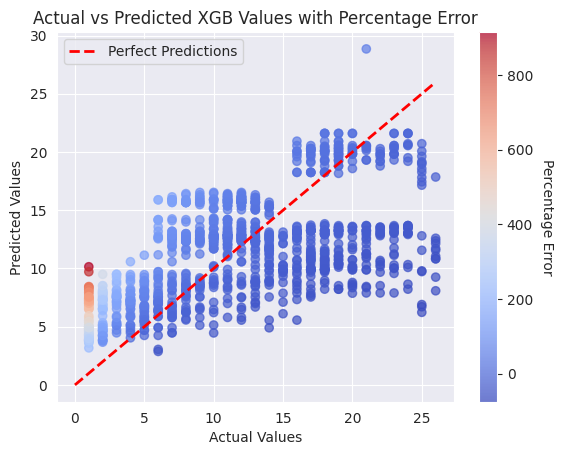

In [17]:
percentage_error = ((y_pred - y_test) / y_test) * 100 #Hoeveel percentage zit het model ernaast

plt.scatter(y_test, y_pred, c=percentage_error, cmap='coolwarm', alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Percentage Error', rotation=270, labelpad=15)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted XGB Values with Percentage Error')

plt.legend()
plt.show()

# Save the for future use

In [18]:
# The best model is the XGBoost model, which is saved in the file XGBoost.sav
pickle.dump(xgb_model, open('models/XGBoost.sav', 'wb'))

# Save other models
pickle.dump(knn_model, open('models/knnmodel.sav', 'wb'))
pickle.dump(lin_model, open('models/linmodel.sav', 'wb'))